In [1]:
import re
import math

In [2]:
import re
import math
import pandas as pd

def extract_data(file_path):
    with open(file_path, 'r') as file:
        content = file.read()

    pattern = r"(\w+ \w+ Model \d+-Bit QAT Model) Prune Iter: (\d+), Test Accuracy: ([\d.]+), Val Accuracy: ([\d.]+), Val Loss: ([\d.]+), Phi Sparsities: \((.*?)\), Rho Sparsities: \((.*?)\)"
    matches = re.findall(pattern, content)

    data = {}
    for match in matches:
        model_name = match[0]
        if model_name not in data:
            data[model_name] = []
        
        phi_sparsities = tuple(map(float, re.findall(r"[\d.]+", match[5])))
        rho_sparsities = tuple(map(float, re.findall(r"[\d.]+", match[6])))
        
        data[model_name].append({
            "iter": int(match[1]),
            "test_accuracy": float(match[2]),
            "val_accuracy": float(match[3]),
            "val_loss": float(match[4]),
            "phi_sparsities": phi_sparsities,
            "rho_sparsities": rho_sparsities
        })

    return data

# def get_linear_bops(in_features, out_features, sparsity, bit_width):
#     return out_features * in_features * ((1-sparsity) * bit_width**2 + 2*bit_width + math.log2(in_features))

def get_linear_bops(in_features, out_features, sparsity, bit_width):
    # Adjust the number of operations based on sparsity
    effective_connections = in_features * out_features * (1 - sparsity)
    
    # Calculate BOPs for multiplication and addition
    mult_bops = effective_connections * bit_width * bit_width
    add_bops = effective_connections * (2 * bit_width + math.ceil(math.log2(in_features)))
    
    return mult_bops + add_bops

def calculate_model_bops(model_name, iteration):
    total_bops = 0
    bit_width = int(re.search(r'(\d+)-Bit', model_name).group(1))
    phi_sparsities = iteration['phi_sparsities']
    rho_sparsities = iteration['rho_sparsities']
    
    def get_phi_sparsity(index):
        return phi_sparsities[index] if index < len(phi_sparsities) else 0

    def get_rho_sparsity(index):
        return rho_sparsities[index] if index < len(rho_sparsities) else 0

    if 'Large' in model_name:
        # Phi layers
        total_bops += get_linear_bops(3, 32, get_phi_sparsity(0), bit_width)
        total_bops += get_linear_bops(32, 32, get_phi_sparsity(1), bit_width)
        
        # Rho layers
        total_bops += get_linear_bops(32, 32, get_rho_sparsity(0), bit_width)
        total_bops += get_linear_bops(32, 64, get_rho_sparsity(1), bit_width)
        total_bops += get_linear_bops(64, 5, get_rho_sparsity(2), bit_width)
    
    elif 'Medium' in model_name:
        # Phi layers
        total_bops += get_linear_bops(3, 32, get_phi_sparsity(0), bit_width)
        total_bops += get_linear_bops(32, 16, get_phi_sparsity(1), bit_width)
        
        # Rho layers
        total_bops += get_linear_bops(16, 64, get_rho_sparsity(0), bit_width)
        total_bops += get_linear_bops(64, 8, get_rho_sparsity(1), bit_width)
        total_bops += get_linear_bops(8, 32, get_rho_sparsity(2), bit_width)
        total_bops += get_linear_bops(32, 5, get_rho_sparsity(3), bit_width)
    
    # Add similar calculations for Small and Tiny models if needed
    
    return total_bops

def analyze_data(data):
    results = []
    for model_name, iterations in data.items():
        for iteration in iterations:
            bops = calculate_model_bops(model_name, iteration)
            results.append({
                "Model": model_name,
                "Iteration": iteration["iter"],
                "Test Accuracy": iteration["test_accuracy"],
                "Val Accuracy": iteration["val_accuracy"],
                "Val Loss": iteration["val_loss"],
                "BOPs": bops
            })
    
    return pd.DataFrame(results)

# # Usage
# file_path = "path_to_your_txt_file.txt"
# extracted_data = extract_data(file_path)
# results_df = analyze_data(extracted_data)
# print(results_df)

In [4]:

# file_path = 'NAC_Compress.txt'
file_path = '/Users/dimademler/Downloads/NAC_Compress2.txt'
data = extract_data(file_path)

results = {}
for model_name, iterations in data.items():
    results[model_name] = {
        "Prune Iter": [],
        "Test Accuracy": [],
        "Val Accuracy": [],
        "Val Loss": [],
        "BOPs": [],
        "Global Sparsity": []
    }
    print(f"\nModel: {model_name}")
    for iteration in iterations:
        bops = calculate_model_bops(model_name, iteration)
        global_sparsity = 1 - (0.8 ** iteration['iter'])

        results[model_name]["Prune Iter"].append(iteration['iter'])
        results[model_name]["Test Accuracy"].append(iteration['test_accuracy'])
        results[model_name]["Val Accuracy"].append(iteration['val_accuracy'])
        results[model_name]["Val Loss"].append(iteration['val_loss'])
        results[model_name]["BOPs"].append(bops)
        results[model_name]["Global Sparsity"].append(global_sparsity)

        print(f"Iteration {iteration['iter']}: {bops:.2e} BOPs, Global Sparsity: {global_sparsity:.4f}")

for model_name, values in results.items():
    df = pd.DataFrame(values)
    filename = f"./plots/Pareto_BOPs/{model_name.replace(' ', '_')}_BOPs.csv"
    df.to_csv(filename, index=False)
    print(f"Results for {model_name} saved to {filename}")



Model: Deepsets Large Model 32-Bit QAT Model
Iteration 0: 4.93e+06 BOPs, Global Sparsity: 0.0000
Iteration 1: 4.70e+06 BOPs, Global Sparsity: 0.2000
Iteration 2: 4.52e+06 BOPs, Global Sparsity: 0.3600
Iteration 3: 4.37e+06 BOPs, Global Sparsity: 0.4880
Iteration 4: 4.26e+06 BOPs, Global Sparsity: 0.5904
Iteration 5: 4.16e+06 BOPs, Global Sparsity: 0.6723
Iteration 6: 4.09e+06 BOPs, Global Sparsity: 0.7379
Iteration 7: 4.03e+06 BOPs, Global Sparsity: 0.7903
Iteration 8: 3.98e+06 BOPs, Global Sparsity: 0.8322
Iteration 9: 3.94e+06 BOPs, Global Sparsity: 0.8658
Iteration 10: 3.91e+06 BOPs, Global Sparsity: 0.8926
Iteration 11: 3.89e+06 BOPs, Global Sparsity: 0.9141
Iteration 12: 3.87e+06 BOPs, Global Sparsity: 0.9313
Iteration 13: 3.86e+06 BOPs, Global Sparsity: 0.9450
Iteration 14: 3.84e+06 BOPs, Global Sparsity: 0.9560
Iteration 15: 3.83e+06 BOPs, Global Sparsity: 0.9648
Iteration 16: 3.83e+06 BOPs, Global Sparsity: 0.9719
Iteration 17: 3.82e+06 BOPs, Global Sparsity: 0.9775
Iteration 

Plot saved as ./plots/Pareto_BOPs/BOPs_vs_Accuracy_colored.png


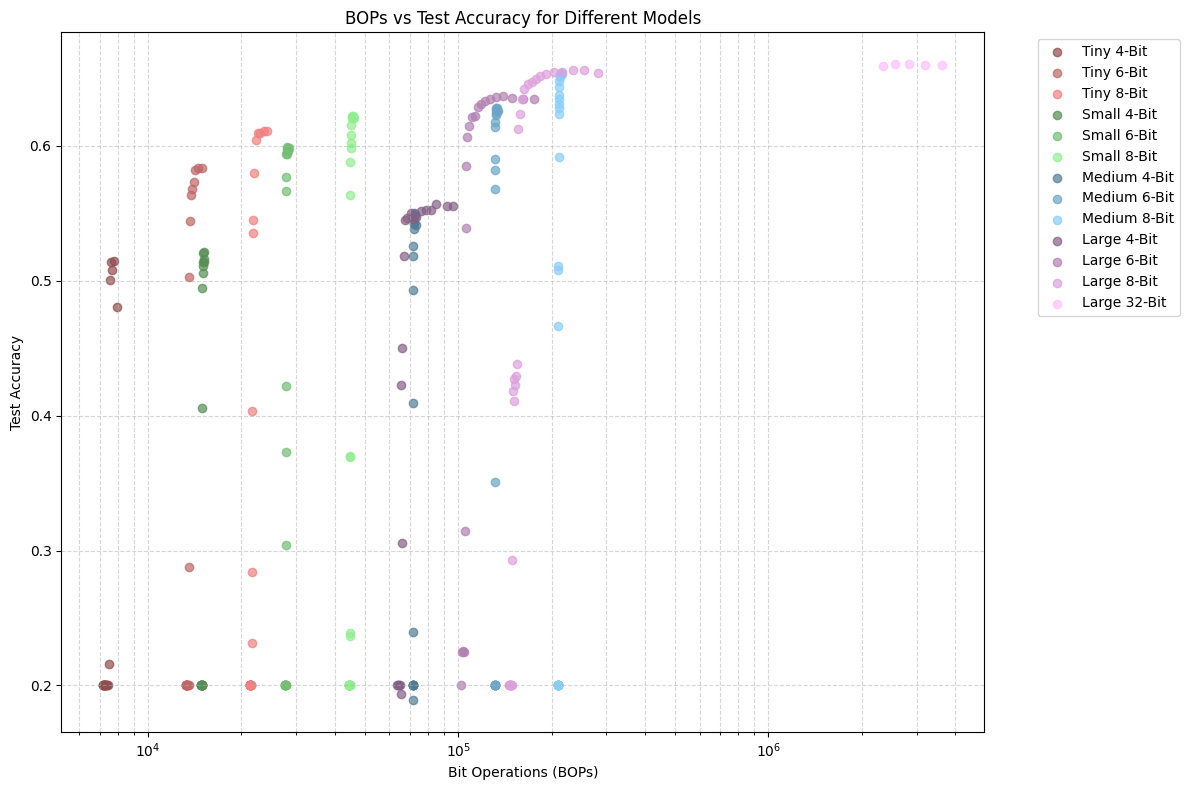

In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import matplotlib.colors as mcolors

def plot_bops_vs_accuracy(csv_folder='./plots/Pareto_BOPs'):
    plt.figure(figsize=(12, 8))
    
    # Define the order of models from smallest to largest
    model_order = ['Tiny', 'Small', 'Medium', 'Large']
    
    color_families = {
        'Tiny': mcolors.CSS4_COLORS['lightcoral'],
        'Small': mcolors.CSS4_COLORS['lightgreen'],
        'Medium': mcolors.CSS4_COLORS['lightskyblue'],
        'Large': mcolors.CSS4_COLORS['plum']
    }

    # Define shade adjustments for different bit widths
    bit_width_shades = {
        '4': 0.6,  # Darker
        '6': 0.8,
        '8': 1.0,  # OG color
        '32': 1.2  # Lighter
    }

    for model_size in model_order:
        for bit_width in ['4', '6', '8', '32']:
            filename = f'Deepsets_{model_size}_Model_{bit_width}-Bit_QAT_Model_BOPs.csv'
            if filename in os.listdir(csv_folder):
                df = pd.read_csv(os.path.join(csv_folder, filename))
                model_name = f'{model_size} {bit_width}-Bit'
                
                # Adjust color based on bit width
                base_color = mcolors.to_rgb(color_families[model_size])
                adjusted_color = [min(1, c * bit_width_shades[bit_width]) for c in base_color]
                
                plt.scatter(df['BOPs'], df['Test Accuracy'], 
                            label=model_name, 
                            alpha=0.7, 
                            color=adjusted_color)

    plt.xscale('log') 
    plt.xlabel('Bit Operations (BOPs)')
    plt.ylabel('Test Accuracy')
    plt.title('BOPs vs Test Accuracy for Different Models')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, which="both", ls="--", alpha=0.5)
    
    plt.tight_layout()
    
    plt.savefig(os.path.join(csv_folder, 'BOPs_vs_Accuracy_colored.png'), dpi=300, bbox_inches='tight')
    print(f"Plot saved as {os.path.join(csv_folder, 'BOPs_vs_Accuracy_colored.png')}")
    
    plt.show()

plot_bops_vs_accuracy()

Plot saved as ./plots/Pareto_BOPs/BOPs_vs_Accuracy_with_Pareto2.png


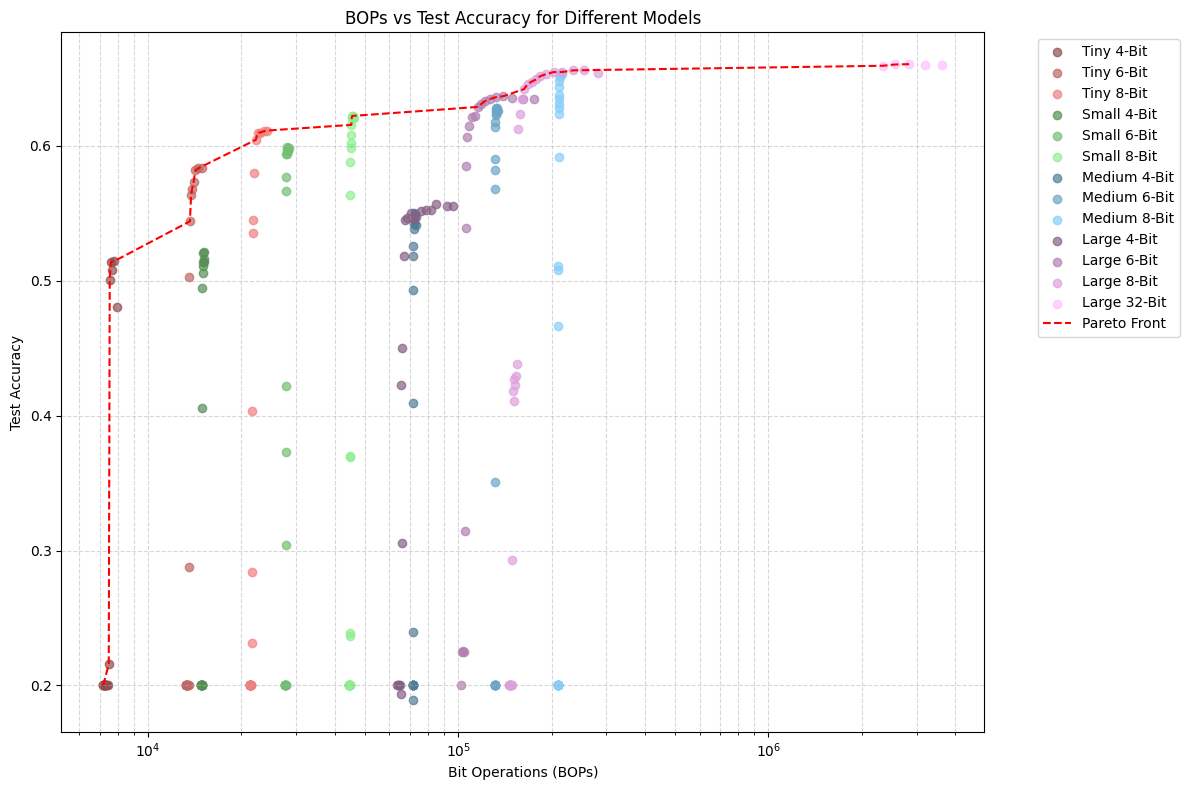

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import matplotlib.colors as mcolors

def is_pareto_efficient(costs):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :return: A (n_points, ) boolean array, indicating whether each point is Pareto efficient
    """
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(costs[is_efficient] < c, axis=1)  # Keep any point with a lower cost
            is_efficient[i] = True  # And keep self
    return is_efficient

def plot_bops_vs_accuracy(csv_folder='./plots/Pareto_BOPs'):
    plt.figure(figsize=(12, 8))
    
    model_order = ['Tiny', 'Small', 'Medium', 'Large']
    color_families = {
        'Tiny': mcolors.CSS4_COLORS['lightcoral'],
        'Small': mcolors.CSS4_COLORS['lightgreen'],
        'Medium': mcolors.CSS4_COLORS['lightskyblue'],
        'Large': mcolors.CSS4_COLORS['plum']
    }
    bit_width_shades = {'4': 0.6, '6': 0.8, '8': 1.0, '32': 1.2}

    all_bops = []
    all_accuracies = []

    for model_size in model_order:
        for bit_width in ['4', '6', '8', '32']:
            filename = f'Deepsets_{model_size}_Model_{bit_width}-Bit_QAT_Model_BOPs.csv'
            if filename in os.listdir(csv_folder):
                df = pd.read_csv(os.path.join(csv_folder, filename))
                model_name = f'{model_size} {bit_width}-Bit'
                
                base_color = mcolors.to_rgb(color_families[model_size])
                adjusted_color = [min(1, c * bit_width_shades[bit_width]) for c in base_color]
                
                plt.scatter(df['BOPs'], df['Test Accuracy'], 
                            label=model_name, 
                            alpha=0.7, 
                            color=adjusted_color)
                
                all_bops.extend(df['BOPs'])
                all_accuracies.extend(df['Test Accuracy'])

    # Calculate Pareto front
    costs = np.array(list(zip(all_bops, [-acc for acc in all_accuracies])))  # Negative accuracy since wanna maximize it
    pareto_efficient = is_pareto_efficient(costs)
    pareto_front = np.array(list(zip(all_bops, all_accuracies)))[pareto_efficient]
    pareto_front = pareto_front[pareto_front[:, 0].argsort()]  # Sort by BOPs

    # Plot Pareto front
    plt.plot(pareto_front[:, 0], pareto_front[:, 1], 'r--', label='Pareto Front')

    plt.xscale('log')
    plt.xlabel('Bit Operations (BOPs)')
    plt.ylabel('Test Accuracy')
    plt.title('BOPs vs Test Accuracy for Different Models')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, which="both", ls="--", alpha=0.5)
    
    plt.tight_layout()
    
    plt.savefig(os.path.join(csv_folder, 'BOPs_vs_Accuracy_with_Pareto2.png'), dpi=300, bbox_inches='tight')
    print(f"Plot saved as {os.path.join(csv_folder, 'BOPs_vs_Accuracy_with_Pareto2.png')}")
    
    plt.show()

# Call the function
plot_bops_vs_accuracy()

Plot saved as ./plots/Pareto_BOPs/BOPs_vs_Accuracy_with_Pareto_and_Highlights3.png


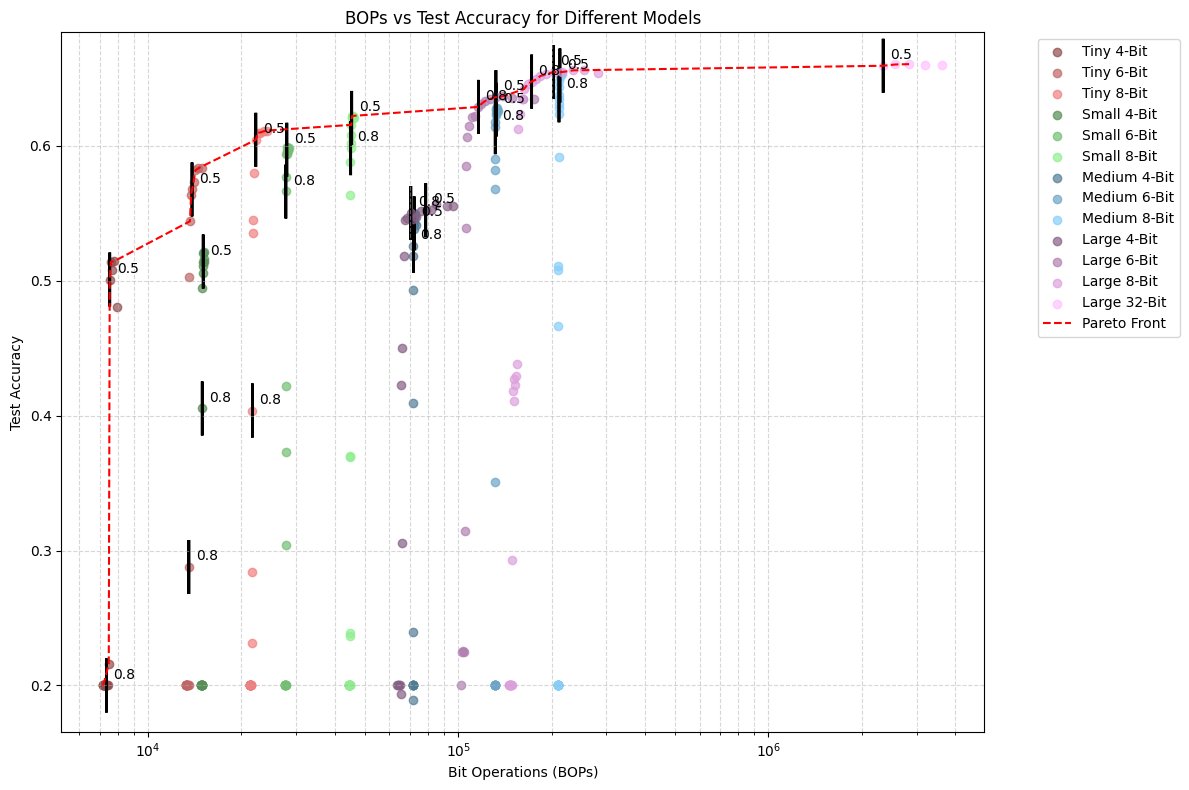

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import matplotlib.colors as mcolors

def is_pareto_efficient(costs):
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(costs[is_efficient] < c, axis=1)
            is_efficient[i] = True
    return is_efficient

def plot_bops_vs_accuracy(csv_folder='./plots/Pareto_BOPs'):
    plt.figure(figsize=(12, 8))
    
    model_order = ['Tiny', 'Small', 'Medium', 'Large']
    color_families = {
        'Tiny': mcolors.CSS4_COLORS['lightcoral'],
        'Small': mcolors.CSS4_COLORS['lightgreen'],
        'Medium': mcolors.CSS4_COLORS['lightskyblue'],
        'Large': mcolors.CSS4_COLORS['plum']
    }
    bit_width_shades = {'4': 0.6, '6': 0.8, '8': 1.0, '32': 1.2}

    all_bops = []
    all_accuracies = []

    for model_size in model_order:
        for bit_width in ['4', '6', '8', '32']:
            filename = f'Deepsets_{model_size}_Model_{bit_width}-Bit_QAT_Model_BOPs.csv'
            if filename in os.listdir(csv_folder):
                df = pd.read_csv(os.path.join(csv_folder, filename))
                model_name = f'{model_size} {bit_width}-Bit'
                
                base_color = mcolors.to_rgb(color_families[model_size])
                adjusted_color = [min(1, c * bit_width_shades[bit_width]) for c in base_color]
                
                plt.scatter(df['BOPs'], df['Test Accuracy'], 
                            label=model_name, 
                            alpha=0.7, 
                            color=adjusted_color)
                
                all_bops.extend(df['BOPs'])
                all_accuracies.extend(df['Test Accuracy'])

                # Highlight points above 0.5 and 0.8 sparsity
                for threshold in [0.5, 0.8]:
                    above_threshold = df['Global Sparsity'] >= threshold
                    if above_threshold.any():
                        first_point = df[above_threshold].iloc[0]
                        circle = plt.Circle((first_point['BOPs'], first_point['Test Accuracy']), 
                                            0.02, 
                                            fill=False, 
                                            edgecolor='black', 
                                            linewidth=2)
                        plt.gca().add_artist(circle)
                        plt.annotate(f'{threshold}', 
                                     (first_point['BOPs'], first_point['Test Accuracy']),
                                     xytext=(5, 5), 
                                     textcoords='offset points')

    # Calculate Pareto front
    costs = np.array(list(zip(all_bops, [-acc for acc in all_accuracies])))  # Negative accuracy because we want to maximize it
    pareto_efficient = is_pareto_efficient(costs)
    pareto_front = np.array(list(zip(all_bops, all_accuracies)))[pareto_efficient]
    pareto_front = pareto_front[pareto_front[:, 0].argsort()]  # Sort by BOPs

    # Plot Pareto front
    plt.plot(pareto_front[:, 0], pareto_front[:, 1], 'r--', label='Pareto Front')

    plt.xscale('log')
    plt.xlabel('Bit Operations (BOPs)')
    plt.ylabel('Test Accuracy')
    plt.title('BOPs vs Test Accuracy for Different Models')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, which="both", ls="--", alpha=0.5)
    
    plt.tight_layout()
    
    plt.savefig(os.path.join(csv_folder, 'BOPs_vs_Accuracy_with_Pareto_and_Highlights3.png'), dpi=300, bbox_inches='tight')
    print(f"Plot saved as {os.path.join(csv_folder, 'BOPs_vs_Accuracy_with_Pareto_and_Highlights3.png')}")
    
    plt.show()

# Call the function
plot_bops_vs_accuracy()

Plot saved as ./plots/Pareto_BOPs/BOPs_vs_Accuracy_with_Pareto_3rd_Iteration.png


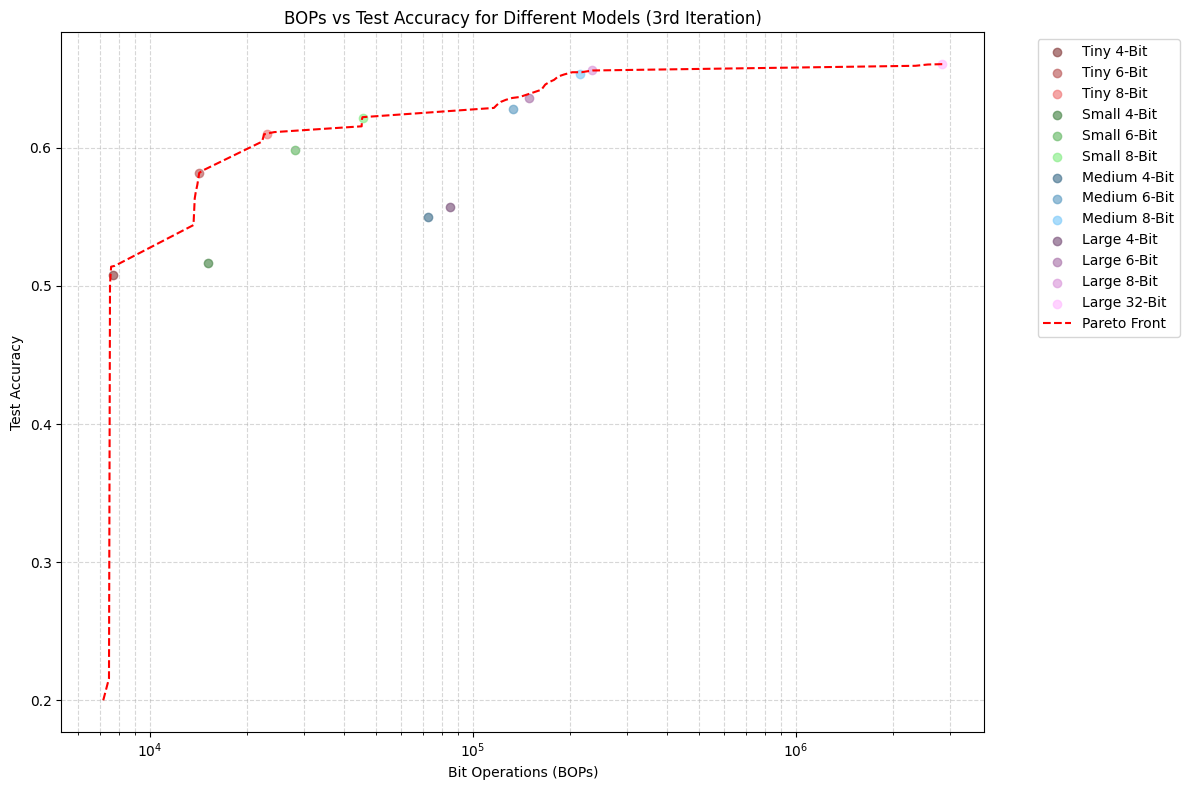

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import matplotlib.colors as mcolors

def is_pareto_efficient(costs):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :return: A (n_points, ) boolean array, indicating whether each point is Pareto efficient
    """
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(costs[is_efficient] < c, axis=1)  # Keep any point with a lower cost
            is_efficient[i] = True  # And keep self
    return is_efficient

def plot_bops_vs_accuracy(csv_folder='./plots/Pareto_BOPs'):
    plt.figure(figsize=(12, 8))
    
    model_order = ['Tiny', 'Small', 'Medium', 'Large']
    color_families = {
        'Tiny': mcolors.CSS4_COLORS['lightcoral'],
        'Small': mcolors.CSS4_COLORS['lightgreen'],
        'Medium': mcolors.CSS4_COLORS['lightskyblue'],
        'Large': mcolors.CSS4_COLORS['plum']
    }
    bit_width_shades = {'4': 0.6, '6': 0.8, '8': 1.0, '32': 1.2}

    all_bops = []
    all_accuracies = []

    for model_size in model_order:
        for bit_width in ['4', '6', '8', '32']:
            filename = f'Deepsets_{model_size}_Model_{bit_width}-Bit_QAT_Model_BOPs.csv'
            if filename in os.listdir(csv_folder):
                df = pd.read_csv(os.path.join(csv_folder, filename))
                model_name = f'{model_size} {bit_width}-Bit'
                
                base_color = mcolors.to_rgb(color_families[model_size])
                adjusted_color = [min(1, c * bit_width_shades[bit_width]) for c in base_color]
                
                # Add all points to lists for Pareto front calculation
                all_bops.extend(df['BOPs'])
                all_accuracies.extend(df['Test Accuracy'])
                
                # Plot only the 3rd iteration (index 2) if it exists
                if len(df) > 2:
                    plt.scatter(df['BOPs'].iloc[2], df['Test Accuracy'].iloc[2], 
                                label=model_name, 
                                alpha=0.7, 
                                color=adjusted_color)
                
                # Plot all points with low opacity
                # plt.scatter(df['BOPs'], df['Test Accuracy'], 
                #             alpha=0.1, 
                #             color=adjusted_color)

    # Calculate Pareto front
    costs = np.array(list(zip(all_bops, [-acc for acc in all_accuracies])))  # Negative accuracy since we want to maximize it
    pareto_efficient = is_pareto_efficient(costs)
    pareto_front = np.array(list(zip(all_bops, all_accuracies)))[pareto_efficient]
    pareto_front = pareto_front[pareto_front[:, 0].argsort()]  # Sort by BOPs

    # Plot Pareto front
    plt.plot(pareto_front[:, 0], pareto_front[:, 1], 'r--', label='Pareto Front')

    plt.xscale('log')
    plt.xlabel('Bit Operations (BOPs)')
    plt.ylabel('Test Accuracy')
    plt.title('BOPs vs Test Accuracy for Different Models (3rd Iteration)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, which="both", ls="--", alpha=0.5)
    
    plt.tight_layout()
    
    plt.savefig(os.path.join(csv_folder, 'BOPs_vs_Accuracy_with_Pareto_3rd_Iteration.png'), dpi=300, bbox_inches='tight')
    print(f"Plot saved as {os.path.join(csv_folder, 'BOPs_vs_Accuracy_with_Pareto_3rd_Iteration.png')}")
    
    plt.show()

# Call the function
plot_bops_vs_accuracy()

Plot saved as ./plots/Pareto_BOPs/BOPs_vs_Accuracy_with_Pareto_3rd_Iteration.png


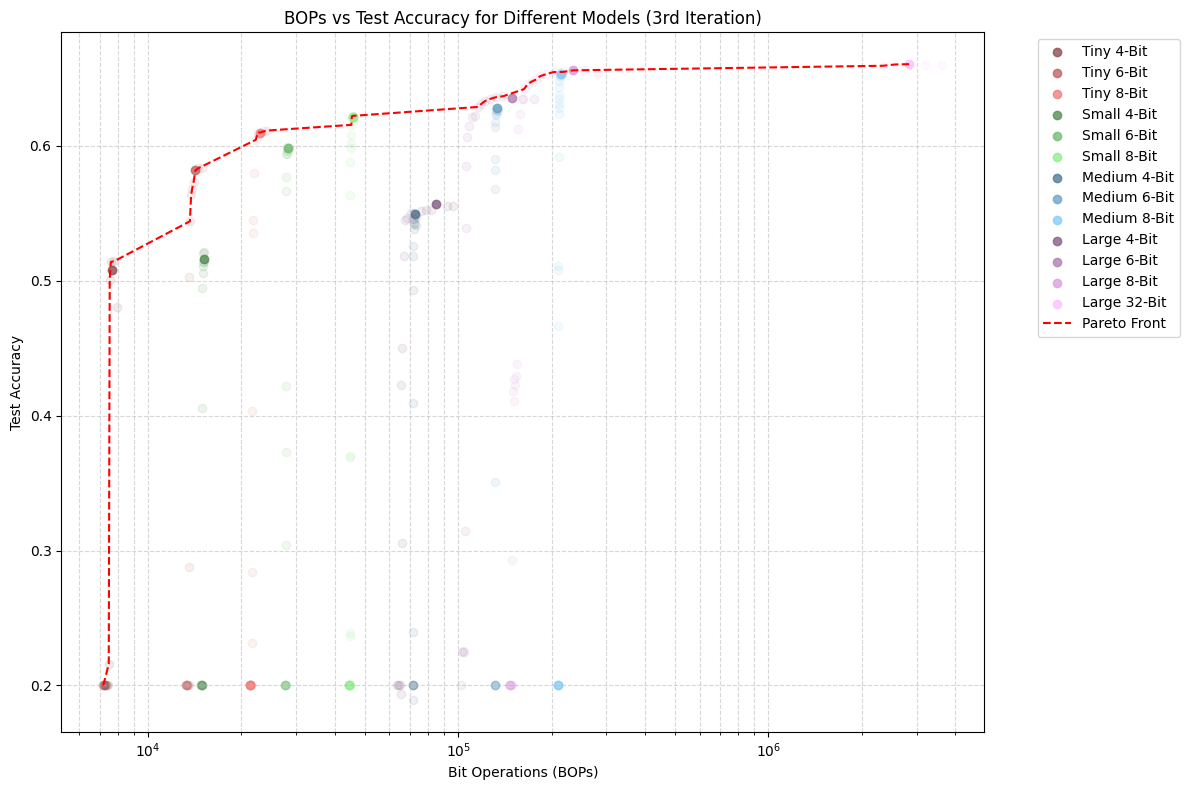

In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import matplotlib.colors as mcolors


def is_pareto_efficient(costs):
    """
    Find the pareto-efficient points
    :param costs: An (n_points, n_costs) array
    :return: A (n_points, ) boolean array, indicating whether each point is Pareto efficient
    """
    is_efficient = np.ones(costs.shape[0], dtype = bool)
    for i, c in enumerate(costs):
        if is_efficient[i]:
            is_efficient[is_efficient] = np.any(costs[is_efficient] < c, axis=1)  # Keep any point with a lower cost
            is_efficient[i] = True  # And keep self
    return is_efficient

def plot_bops_vs_accuracy(csv_folder='./plots/Pareto_BOPs'):
    plt.figure(figsize=(12, 8))
    
    model_order = ['Tiny', 'Small', 'Medium', 'Large']
    color_families = {
        'Tiny': mcolors.CSS4_COLORS['lightcoral'],
        'Small': mcolors.CSS4_COLORS['lightgreen'],
        'Medium': mcolors.CSS4_COLORS['lightskyblue'],
        'Large': mcolors.CSS4_COLORS['plum']
    }
    bit_width_shades = {'4': 0.6, '6': 0.8, '8': 1.0, '32': 1.2}

    all_bops = []
    all_accuracies = []

    for model_size in model_order:
        for bit_width in ['4', '6', '8', '32']:
            filename = f'Deepsets_{model_size}_Model_{bit_width}-Bit_QAT_Model_BOPs.csv'
            if filename in os.listdir(csv_folder):
                df = pd.read_csv(os.path.join(csv_folder, filename))
                model_name = f'{model_size} {bit_width}-Bit'
                
                base_color = mcolors.to_rgb(color_families[model_size])
                adjusted_color = [min(1, c * bit_width_shades[bit_width]) for c in base_color]
                
                # Add all points to lists for Pareto front calculation
                all_bops.extend(df['BOPs'])
                all_accuracies.extend(df['Test Accuracy'])
                
                # Plot only the 3rd iteration (index 2) if it exists
                if len(df) > 2:
                    plt.scatter(df['BOPs'].iloc[2], df['Test Accuracy'].iloc[2], 
                                label=model_name, 
                                alpha=0.8, 
                                color=adjusted_color)
                
                # Plot all points with low opacity
                plt.scatter(df['BOPs'], df['Test Accuracy'], 
                            alpha=0.1, 
                            color=adjusted_color)

    # Calculate Pareto front
    costs = np.array(list(zip(all_bops, [-acc for acc in all_accuracies])))  # Negative accuracy since we want to maximize it
    pareto_efficient = is_pareto_efficient(costs)
    pareto_front = np.array(list(zip(all_bops, all_accuracies)))[pareto_efficient]
    pareto_front = pareto_front[pareto_front[:, 0].argsort()]  # Sort by BOPs

    # Plot Pareto front
    plt.plot(pareto_front[:, 0], pareto_front[:, 1], 'r--', label='Pareto Front')

    plt.xscale('log')
    plt.xlabel('Bit Operations (BOPs)')
    plt.ylabel('Test Accuracy')
    plt.title('BOPs vs Test Accuracy for Different Models (3rd Iteration)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, which="both", ls="--", alpha=0.5)
    
    plt.tight_layout()
    
    plt.savefig(os.path.join(csv_folder, 'BOPs_vs_Accuracy_with_Pareto_3rd_Iteration.png'), dpi=300, bbox_inches='tight')
    print(f"Plot saved as {os.path.join(csv_folder, 'BOPs_vs_Accuracy_with_Pareto_3rd_Iteration.png')}")
    
    plt.show()

# Call the function
plot_bops_vs_accuracy()